In [268]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pickle
import pandas as pd

from torch.optim import Optimizer

from optimizers import DiscreteStateOptimizer
# import torchcubicspline as tcs



In [269]:
device = torch.device("cuda")

In [270]:


def load_data(file_path, column, rows=None):
    """Generic function to load data from an Excel file."""
    df = pd.read_excel(file_path)
    return list(df[column][rows]) if rows else list(df[column])

POTENTIATION_DATASETS = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "potentiation (mS)", range(30)),
    "vivek": ("data/new_data_50_pulses.xlsx", "Potentiation", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Potentiation", range(128))
}
DEPRESSION_DATASETS = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "Depression", None),
    "vivek": ("data/new_data_50_pulses.xlsx", "Depression", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Depression", None)
}
# Select potentiation data
data_choice = "himanshu" 

potentiation = load_data(*POTENTIATION_DATASETS.get(data_choice, (None, None, None)))
depression = load_data(*DEPRESSION_DATASETS.get(data_choice, (None, None, None)))



In [271]:
import torch

def map_to_nearest_indices(given_list, reference_list):
    given_tensor = torch.tensor(given_list, dtype=torch.float32)
    reference_tensor = torch.tensor(reference_list, dtype=torch.float32)
    
    # Compute absolute differences and find nearest indices
    indices = torch.abs(reference_tensor.unsqueeze(0) - given_tensor.unsqueeze(-1)).argmin(dim=-1)
    
    return indices.tolist()

# Example usage
given_list = [3.2, 7.8, 1.5]
reference_list = [1.0, 2.0, 3.0, 5.0, 8.0]
mapping = map_to_nearest_indices(given_list, reference_list)
print(mapping)  # Output: Indices in reference_list that are closest to values in given_list


[2, 4, 0]


In [272]:
def adjusted_list(values, flag = True):
    new_values = values[:1]  # Start with the first element
    for i in range(1, len(values)):
        if flag:
            new_values.append(max(new_values[-1], values[i]))  # Ensure non-decreasing order
        else:
            new_values.append(min(new_values[-1], values[i]))  # Ensure non-decreasing order

    return new_values

potentiation = adjusted_list(potentiation)
depression = adjusted_list(depression, False)


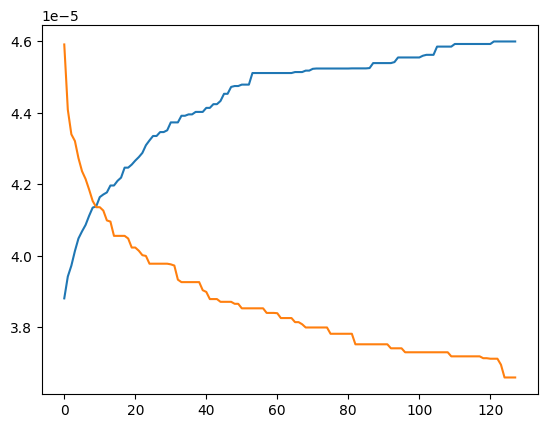

In [273]:
plt.plot(potentiation)
plt.plot(depression)

In [274]:
potentiation_g_by_g0, depression_g_by_g0 = [], []

for i in range(len(potentiation)):
    if i == len(potentiation)-1:
        x = potentiation_g_by_g0[-1]
        
    else:
        x = potentiation[i+1]/potentiation[i]    
    potentiation_g_by_g0.append(x)


for i in range(len(depression)):
    if i == len(depression)-1:
        x = depression_g_by_g0[-1]
    else:
        x = depression[i+1]/depression[i]

    
    depression_g_by_g0.append(x)

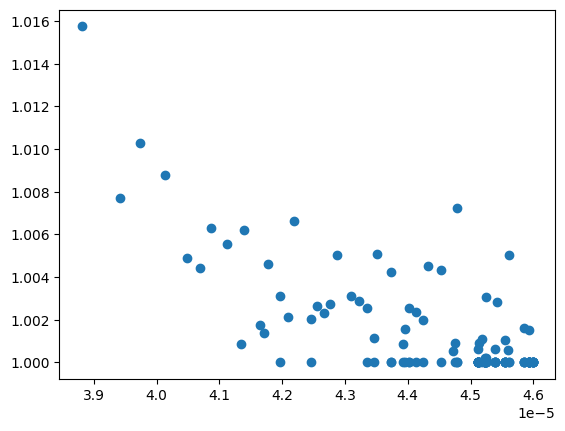

In [275]:
plt.scatter(potentiation, potentiation_g_by_g0)
# plt.plot(depression_conductances, depression_g_by_g0)

In [276]:
# # Given unsorted x and y tensors
# x = torch.tensor(potentiation_conductances, dtype=torch.float32)
# y = torch.tensor(potentiation_g_by_g0, dtype=torch.float32)

# # Sort x and reorder y accordingly
# sorted_indices = torch.argsort(x)
# x_sorted = x[sorted_indices]
# y_sorted = y[sorted_indices]

# # Now fit the spline
# spline = tcs.NaturalCubicSpline(x_sorted, y_sorted)


In [277]:
# import torch

# class PolynomialRegressor:
#     def __init__(self, degree=3):
#         self.degree = degree
#         self.coeffs = None
#         self.x_mean = None
#         self.x_std = None

#     def fit(self, x, y):
#         # Normalize x
#         self.x_mean = x.mean()
#         self.x_std = x.std()
#         x_norm = (x - self.x_mean) / self.x_std

#         # Create polynomial feature matrix
#         X_poly = torch.vander(x_norm, N=self.degree + 1)
        
#         # Solve least squares
#         self.coeffs = torch.linalg.lstsq(X_poly, y).solution
        
#         # Evaluate fit quality
#         y_pred = self.predict(x)
#         mse = torch.mean((y - y_pred) ** 2).item()
#         ss_total = torch.sum((y - y.mean()) ** 2)
#         ss_residual = torch.sum((y - y_pred) ** 2)
#         r2_score = 1 - (ss_residual / ss_total) if ss_total > 0 else 0.0

#         print(f"Fit Quality Metrics:\n - Mean Squared Error (MSE): {mse:.8f}\n - R² Score: {r2_score:.6f}")

#     def predict(self, x):
#         if self.coeffs is None:
#             raise ValueError("Model not fitted yet. Call fit() first.")

#         # Normalize x using the stored mean and std
#         x_norm = (x - self.x_mean) / self.x_std
#         X_poly = torch.vander(x_norm, N=self.degree + 1)
        
#         return X_poly @ self.coeffs
    

#     def plot_residuals(self, x, y):
#         y_pred = self.predict(x)
#         residuals = y.numpy() - y_pred.numpy()
        
#         plt.figure(figsize=(6, 4))
#         plt.scatter(x.numpy(), residuals, color='blue', alpha=0.6, label='Residuals')
#         plt.axhline(0, color='red', linestyle='--')
#         plt.xlabel('X values')
#         plt.ylabel('Residuals')
#         plt.title('Residual Plot')
#         plt.legend()
#         plt.show()

#         # Check residual distribution
#         if np.abs(residuals).mean() > 0.01:
#             print("Warning: Residuals are not close to zero. Consider using a different model or transformation.")
        
#         return residuals

import torch
import numpy as np
import matplotlib.pyplot as plt

class PolynomialRegressor:
    def __init__(self, degree=3, device=None):
        self.degree = degree
        self.coeffs = None
        self.x_mean = None
        self.x_std = None
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")

    def fit(self, x, y):
        x = torch.tensor(x, dtype=torch.float32, device=self.device)
        y = torch.tensor(y, dtype=torch.float32, device=self.device)

        # Normalize x
        self.x_mean = x.mean()
        self.x_std = x.std()
        x_norm = (x - self.x_mean) / self.x_std

        # Create polynomial feature matrix
        X_poly = torch.vander(x_norm, N=self.degree + 1)
        
        # Solve least squares on GPU
        self.coeffs = torch.linalg.lstsq(X_poly, y).solution

        # Evaluate fit quality
        y_pred = self.predict(x)
        mse = torch.mean((y - y_pred) ** 2).item()
        ss_total = torch.sum((y - y.mean()) ** 2)
        ss_residual = torch.sum((y - y_pred) ** 2)
        r2_score = 1 - (ss_residual / ss_total) if ss_total > 0 else 0.0

        print(f"Fit Quality Metrics:\n - Mean Squared Error (MSE): {mse:.8f}\n - R² Score: {r2_score:.6f}")

    def predict(self, x):
        if self.coeffs is None:
            raise ValueError("Model not fitted yet. Call fit() first.")

        x = torch.tensor(x, dtype=torch.float32, device=self.device)
        x_norm = (x - self.x_mean) / self.x_std
        X_poly = torch.vander(x_norm, N=self.degree + 1)

        return X_poly @ self.coeffs

    def plot_residuals(self, x, y):
        x = torch.tensor(x, dtype=torch.float32, device=self.device)
        y = torch.tensor(y, dtype=torch.float32, device=self.device)

        y_pred = self.predict(x)
        residuals = (y - y_pred).cpu().numpy()  # Move to CPU for plotting

        plt.figure(figsize=(6, 4))
        plt.scatter(x.cpu().numpy(), residuals, color='blue', alpha=0.6, label='Residuals')
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('X values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.legend()
        plt.show()

        # Check residual distribution
        if np.abs(residuals).mean() > 0.01:
            print("Warning: Residuals are not close to zero. Consider using a different model or transformation.")

        return residuals


Fit Quality Metrics:
 - Mean Squared Error (MSE): 0.00000192
 - R² Score: 0.686436


C:\Users\adith\AppData\Local\Temp\ipykernel_8064\2199213058.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=self.device)
C:\Users\adith\AppData\Local\Temp\ipykernel_8064\2199213058.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32, device=self.device)
C:\Users\adith\AppData\Local\Temp\ipykernel_8064\2199213058.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=self.device)


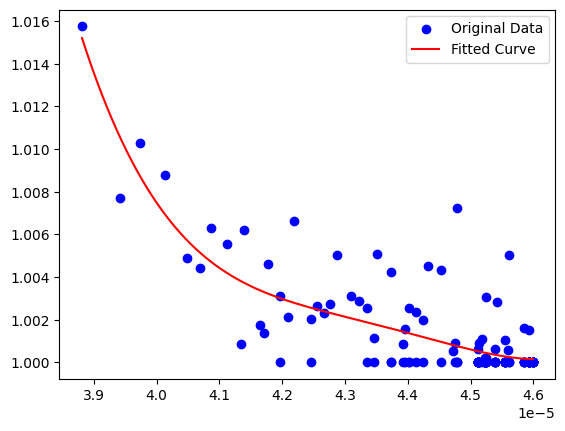

In [279]:
import matplotlib.pyplot as plt

# Example data (replace with actual x, y tensors)
# x = torch.linspace(0, 10, steps=10)
# y = torch.sin(x) + 0.1 * torch.randn_like(x)  # Noisy data
x = torch.tensor(potentiation)
y = torch.tensor(potentiation_g_by_g0)
# x = torch.tensor(depression)
# y = torch.tensor(depression_g_by_g0)
# Fit the model
model = PolynomialRegressor(degree=4)
model.fit(x, y)

# Predict values for a smooth curve
x_dense = torch.linspace(x.min(), x.max(), steps=1000)
y_pred = model.predict(x_dense)

# Plot original points and fitted curve
plt.scatter(x, y, label="Original Data", color="blue")
plt.plot(x_dense.cpu(), y_pred.cpu(), label="Fitted Curve", color="red")
plt.legend()
plt.show()


C:\Users\adith\AppData\Local\Temp\ipykernel_8064\2199213058.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=self.device)
C:\Users\adith\AppData\Local\Temp\ipykernel_8064\2199213058.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32, device=self.device)
C:\Users\adith\AppData\Local\Temp\ipykernel_8064\2199213058.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=self.device)


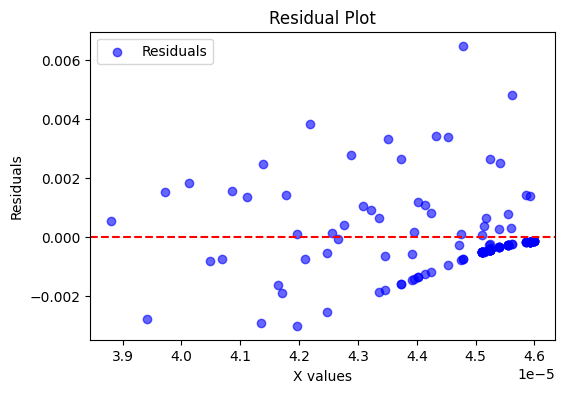

array([ 5.5098534e-04, -2.7899742e-03,  1.5220642e-03,  1.8347502e-03,
       -8.2993507e-04, -7.5769424e-04,  1.5648603e-03,  1.3686419e-03,
       -2.9205084e-03,  2.4847984e-03, -1.6108751e-03, -1.9046068e-03,
        1.4094114e-03, -3.0051470e-03,  9.5367432e-05, -7.3003769e-04,
        3.8225651e-03, -2.5482178e-03, -5.4025650e-04,  1.4948845e-04,
       -8.4280968e-05,  4.1699409e-04,  2.7887821e-03,  1.0410547e-03,
        8.9812279e-04, -1.8758774e-03,  6.5076351e-04, -1.7939806e-03,
       -6.3514709e-04,  3.3015013e-03, -1.5885830e-03, -1.5885830e-03,
        2.6555061e-03, -1.4444590e-03, -5.6767464e-04, -1.4142990e-03,
        1.5807152e-04, -1.3598204e-03, -1.3598204e-03,  1.2005568e-03,
       -1.2705326e-03,  1.0883808e-03, -1.1876822e-03,  8.1300735e-04,
        3.4173727e-03, -9.5736980e-04,  3.3727884e-03, -2.5629997e-04,
       -7.8797340e-04,  9.5605850e-05, -7.5781345e-04, -7.5781345e-04,
        6.4749718e-03, -5.2428246e-04, -5.2428246e-04, -5.2428246e-04,
      

In [280]:
model.plot_residuals(x, y)

In [281]:
class ContinuousOptimizer(Optimizer):
    def __init__(self, params, potentiation:list, depression:list):
        if not isinstance(potentiation, list):
            raise ValueError("potentiation should be a list")
        if not isinstance(depression, list):
            raise ValueError("depression should be a list")
        
        potentiation_g_by_g0, depression_g_by_g0 = [], []

        for i in range(len(potentiation)):
            if i == len(potentiation)-1:
                x = potentiation_g_by_g0[-1]
                
            else:
                x = potentiation[i+1]/potentiation[i]    
            potentiation_g_by_g0.append(x)


        for i in range(len(depression)):
            if i == len(depression)-1:
                x = depression_g_by_g0[-1]
            else:
                x = depression[i+1]/depression[i]

            
            depression_g_by_g0.append(x)
        
        self.potentiation_model = PolynomialRegressor(degree=5)
        self.potentiation_model.fit(potentiation, potentiation_g_by_g0)

        self.depression_model = PolynomialRegressor(degree=5)
        self.depression_model.fit(depression, depression_g_by_g0)

        self.min_conductance, self.max_conductance = 3.9e-5, 4.6e-5
        self.min_weight, self.max_weight = -1.0, 1.0

        super(ContinuousOptimizer).__init__(params)

    
    def step(self):
        def map_weights_to_conductance(weight, min_weight, 
                                       max_weight=self.max_weight, 
                                       min_conductance=self.min_conductance, 
                                       max_conductance=self.max_conductance):
            mid_weight = (max_weight+min_weight)/2
            mid_conductance = (max_conductance + min_conductance)/2
            normalized_weight = (weight - mid_weight)/(max_weight-mid_weight)
            # normalized_conductance = 2/torch.pi * torch.arcsin(normalized_weight)
            # normalized_conductance = torch.sign(normalized_weight) * torch.abs(normalized_weight) ** (1/3)
            # normalized_conductance = normalized_weight ** 5
            normalized_conductance = normalized_weight
            conductance = normalized_conductance * (max_conductance - mid_conductance) + mid_conductance
            return conductance
        
        def map_conductance_to_weights(conductance, 
                                            min_weight=self.min_weight, 
                                            max_weight=self.max_weight, 
                                            min_conductance=self.min_conductance, 
                                            max_conductance=self.max_conductance):
            mid_weight = (max_weight+min_weight)/2
            mid_conductance = (max_conductance + min_conductance)/2
            normalized_conductance = (conductance - mid_conductance)/(max_conductance - mid_conductance)
            # normalized_weight = torch.sin(normalized_conductance * torch.pi/2)
            # normalized_weight = torch.sign(normalized_conductance) * torch.abs(normalized_conductance) ** (1/5)
            # normalized_weight = normalized_conductance ** 3
            normalized_weight = normalized_conductance
            weight = normalized_weight*(max_weight - mid_weight) + mid_weight
            return weight
        
        def new_conductance(G0, grad):
            
            # G_pos = G0*1.05
            # G_neg = G0*(0.95)
            # Apply the splines based on gradient
            tau = 0.05
            # Masks for set, reset, and no change conditions
            set_mask = torch.ge(grad, tau)       # Apply set spline if grad >= tau
            reset_mask = torch.le(grad, -tau)    # Apply reset spline if grad <= -tau

            # Apply the set and reset splines
            # G_pos = G0 * self.reset_splines['1 us'].ev(G0, -1.85)    # Set spline adjustment
            # G_neg = G0 * self.set_splines['1 us'].ev(G0, 1.83) # Reset spline adjustment
            # G_pos = G0 * self.reset_splines(G0)
            # G_neg = G0 * self.set_splines(G0)

            # G_neg = G0 +1.0410955555555556e-09/5
            # G_pos = G0 -2.4080184210526313e-09/5
            G_neg = self.potentiation_model(G0)
            G_pos = self.depression_model(G0)

            # Use torch.where to select G_pos, G_neg, or G0 based on conditions
            G_new = torch.where(set_mask, G_pos, torch.where(reset_mask, G_neg, G0))

            return G_new
            # positive_mask = torch.le(grad, 0)  # Check for grad >= 0
            # G_pos = G0 * (self.set_splines['1 us'].ev(G0, 2.5))
            # G_neg = G0 * (self.reset_splines['1 us'].ev(G0, -2.5))
            
            # # # Combine both positive and negative cases
            # G_new = torch.where(positive_mask, G_pos, G_neg)
            # return G_new
        

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                weight, grad = p.data, p.grad

                G0 = map_weights_to_conductance(
                    weight=weight,
                )


                G0 = torch.clamp(G0, min=self.min_conductance, max=self.max_conductance)

                G_new = new_conductance(G0=G0, grad=grad)

                new_weight = map_conductance_to_weights(
                    conductance=G_new
                )
                p.data.copy_(new_weight)




        
        